In [4]:
import numpy as np
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from model import *
import random
from mpl_toolkits.mplot3d import Axes3D
from optimisation import *

First we look at the evolution of MTD for the mean parameters observed in the PCV treatment.

In [2]:
y0_PCV = (1.0, 7.13, 41.2, 0.0) #Initial conditions
parameters_PCV = {
    "lambda_p":0.121,
    "k_P_Q":0.0295,
    "k_Qp_P":0.0031, 
    "delta_Qp":0.00867,
    "gamma":0.729, 
    "KDE":0.24, 
    "K":100
    } #Parameters lambda_p, k_P_Q, k_Qp_P, delta_Qp, gamma_P, gamma_Q, KDE, K

y0_TMZ = (1.0, 0.924, 42.3, 0.0) #Initial conditions
parameters_TMZ = {
    "lambda_p":0.114,
    "k_P_Q":0.0226,
    "k_Qp_P":0.0045, 
    "delta_Qp":0.0214,
    "gamma":0.842, 
    "KDE":0.32, 
    "K":100
    }

y0_rad = (1.0, 3.89, 40.3, 0.0)
parameters_rad ={
    "lambda_p":0.138,
    "k_P_Q":0.0249,
    "k_Qp_P":0.000001, 
    "delta_Qp":0.0125,
    "gamma":1.71, 
    "KDE":0.317, 
    "K":100
    }

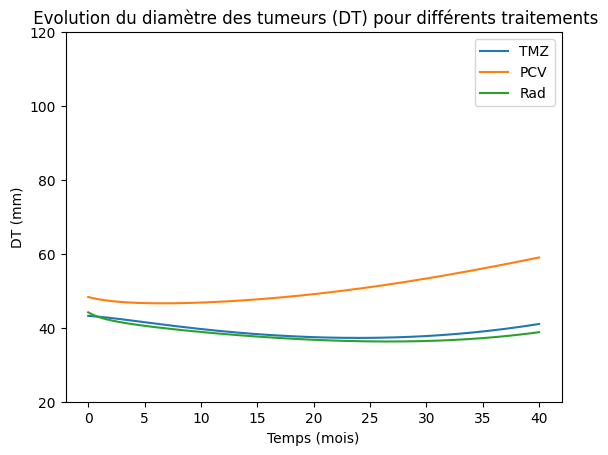

In [6]:
y_TMZ = odeint(derivees, y0_TMZ, np.linspace(0, 40, 400), args=(parameters_TMZ, ))
y_PCV = odeint(derivees, y0_PCV, np.linspace(0, 40, 400), args=(parameters_PCV, ))
y_rad = odeint(derivees, y0_rad, np.linspace(0, 40, 400), args=(parameters_rad, ))



plt.plot(np.linspace(0, 40, 400), y_TMZ[:, 1] + y_TMZ[:, 2] + y_TMZ[:, 3], label='TMZ')
plt.plot(np.linspace(0, 40, 400), y_PCV[:, 1] + y_PCV[:, 2] + y_PCV[:, 3], label='PCV')
plt.plot(np.linspace(0, 40, 400), y_rad[:, 1] + y_rad[:, 2] + y_rad[:, 3], label='Rad')
plt.xlabel('Temps (mois)')
plt.ylabel('DT (mm)')
plt.title(' Evolution du diamètre des tumeurs (DT) pour différents traitements')
plt.legend()
plt.ylim(20, 120)
plt.show()

3 Parameters are associated to tumors, are Q0, P0 and $\lambda_{P}$. When doing individual prediction, $\lambda_{P}$ is estimated from the patient and the other parameters considered are mean parameters. The MTD is measured at time of treatment and P0 is considered to be 10% of the MTD. (At what size are LGG detected ?)

Lets generate size of tumor (MTD) between 30 and 85 and associate a $\lambda_{P}$. But is $\lambda_{P}$ dependant on size ?

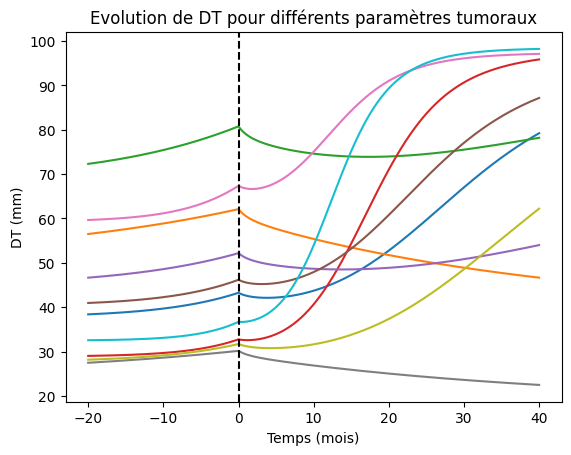

In [7]:
def random_evolution_MTD(param):
    
    MTD = random.uniform(30, 85)
    P0 = 0.1*MTD
    Q0 = MTD - P0

    value = np.random.normal(0.121, 0.121*72/100)
    if value >= 0:
        lambda_p = value
    else:
        lambda_p = 0
        
    #The other parameters are the one of TMZ
    y0 = (1.0, P0, Q0, 0.0)
    y0_growth = (0.0, P0, Q0, 0.0)
    parameters["lambda_p"] = lambda_p
    parameters_growth = (lambda_p, parameters["k_P_Q"], 100)

    y = odeint(derivees, y0, np.linspace(0, 80, 800), args=(parameters, ))
    y_growth = odeint(growth_no_treatment, y0_growth, np.linspace(0, 20, 200), args=(parameters_growth, ))
    evol = np.concatenate((np.flip(y_growth), y), axis=0)
    return evol, (P0, Q0, lambda_p)

Param = []
for i in range(10):
    evol, param = random_evolution_MTD(parameters_TMZ)
    plt.plot(np.concatenate((np.linspace(-20, 0, 200), np.linspace(0, 40, 800))), evol[:, 1] + evol[:, 2] + evol[:, 3], label = str(i))
    Param += [param]

plt.axvline(x=0, color='k', linestyle='--')
plt.xlabel('Temps (mois)')
plt.ylabel('DT (mm)')
plt.title('Evolution de DT pour différents paramètres tumoraux')

plt.show()

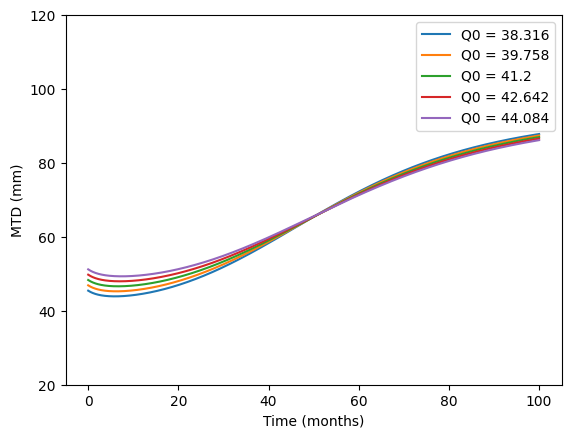

In [99]:

#Testing different initial conditions we make the initial conditions vary according to the interindividuality observed for the PCV

#P0 in [5.35; 8.917] because mean P0 = 7.13 with CV of 94%
    #Q0 in [38.316; 44.084] because mean Q0 = 41.2 with CV of 25%

Y = []
for P0 in np.linspace(5.35, 8.917, 5):
    for Q0 in np.linspace(38.316, 44.084, 5):
        y0 = (1.0, P0, Q0, 0.0)
        y = odeint(derivees, y0, np.linspace(0, 100, 1000), args=(parameters_PCV, ))
        Y += [y]


plt.plot(np.linspace(0, 100, 1000), Y[10][:, 1] + Y[10][:, 2] + Y[10][:, 3], label='Q0 = 38.316') 
plt.plot(np.linspace(0, 100, 1000), Y[11][:, 1] + Y[11][:, 2] + Y[11][:, 3], label='Q0 = 39.758')
plt.plot(np.linspace(0, 100, 1000), Y[12][:, 1] + Y[12][:, 2] + Y[12][:, 3], label='Q0 = 41.2')
plt.plot(np.linspace(0, 100, 1000), Y[13][:, 1] + Y[13][:, 2] + Y[13][:, 3], label='Q0 = 42.642')
plt.plot(np.linspace(0, 100, 1000), Y[14][:, 1] + Y[14][:, 2] + Y[14][:, 3], label='Q0 = 44.084')
plt.ylim(20, 120)
plt.xlabel('Time (months)')
plt.ylabel('MTD (mm)')
plt.legend()
plt.show()



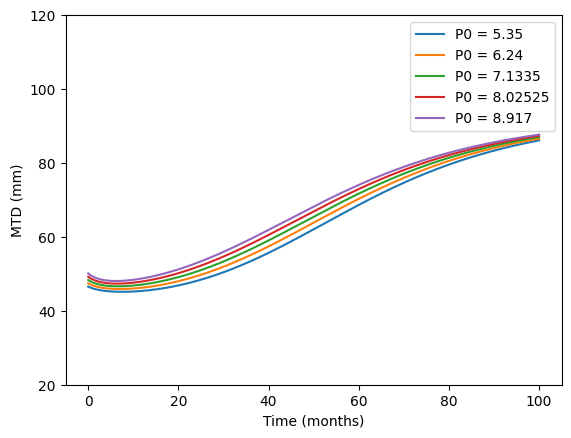

In [100]:
plt.plot(np.linspace(0, 100, 1000), Y[2][:, 1] + Y[2][:, 2] + Y[2][:, 3], label='P0 = 5.35') 
plt.plot(np.linspace(0, 100, 1000), Y[7][:, 1] + Y[7][:, 2] + Y[7][:, 3], label='P0 = 6.24')
plt.plot(np.linspace(0, 100, 1000), Y[12][:, 1] + Y[12][:, 2] + Y[12][:, 3], label='P0 = 7.1335')
plt.plot(np.linspace(0, 100, 1000), Y[17][:, 1] + Y[17][:, 2] + Y[17][:, 3], label='P0 = 8.02525')
plt.plot(np.linspace(0, 100, 1000), Y[22][:, 1] + Y[22][:, 2] + Y[22][:, 3], label='P0 = 8.917')
plt.ylim(20, 120)
plt.xlabel('Time (months)')
plt.ylabel('MTD (mm)')
plt.legend()
plt.show()


We see on the next figure that the bigger the P0 the later the minimum MTD occur. 

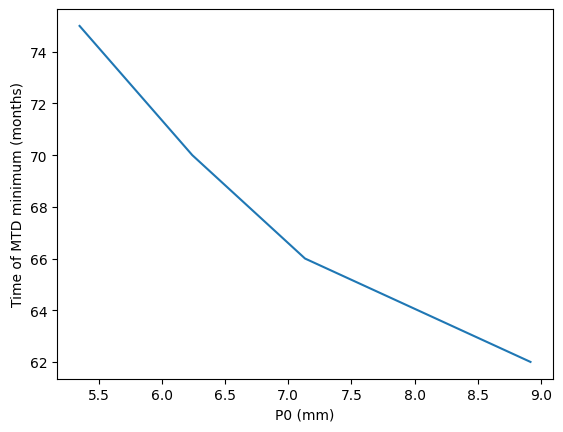

In [101]:
P01 = Y[2][:, 1] + Y[2][:, 2] + Y[2][:, 3]
P02 = Y[7][:, 1] + Y[7][:, 2] + Y[7][:, 3]
P03 = Y[12][:, 1] + Y[12][:, 2] + Y[12][:, 3]
P04 = Y[17][:, 1] + Y[17][:, 2] + Y[17][:, 3]
P05 = Y[22][:, 1] + Y[22][:, 2] + Y[22][:, 3]

min_index = [np.argmin(P01), np.argmin(P02), np.argmin(P03), np.argmin(P04), np.argmin(P05)]


plt.plot(np.linspace(5.35, 8.917, 5), min_index)
plt.xlabel('P0 (mm)')
plt.ylabel('Time of MTD minimum (months)')
plt.show()

In the article, we are given with the mean parameters the CV (Coefficient of variation) in %. $CV = \frac{\sigma}{\mu}$

Here is the 3D phase portrait in function of Q, P and $\lambda_{p}$.

We see that no matter P or Q, given the parameters of the TMZ treatment, we will get a decrease of Q and P and an increase of Qp when C = 1. But this is not always the case for some value of C, P and Q will increase at least when they are equal to the mean values PO Q0. (as we saw on the trajectory we plotted for the mean parameters)
But what 

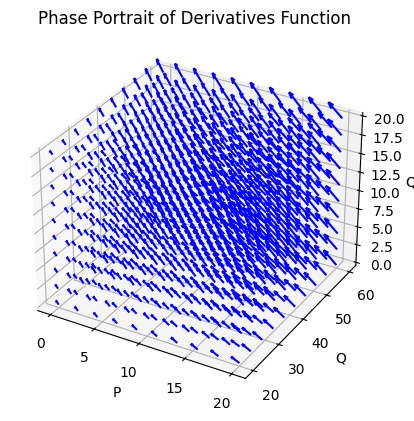

In [10]:
plot_3D_phase_portrait(0.8, parameters_TMZ)

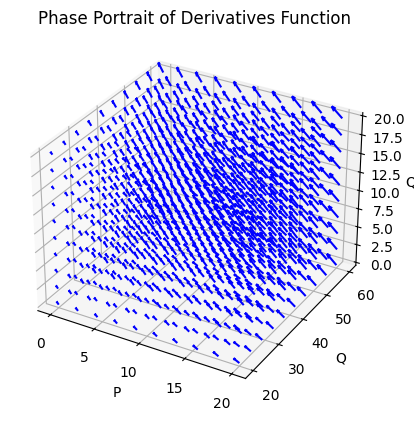

In [11]:
plot_3D_phase_portrait(0.6, parameters_TMZ)

We can suppose that treatment efficacy $\gamma$ will be determinant for the evolution of tumor size. We are going to plot the mean MTD in function of $\frac{\lambda}{\gamma}$.

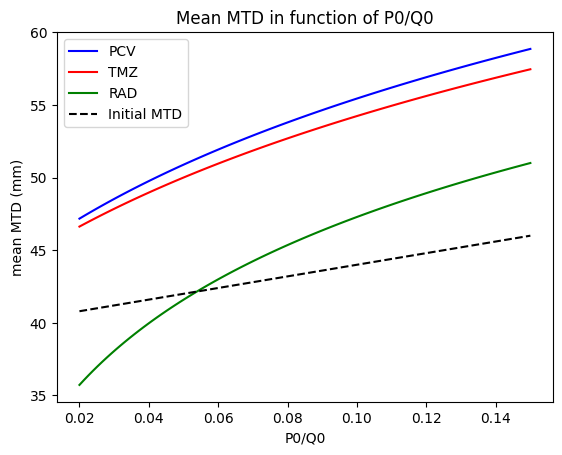

In [5]:
def initial_Pstar():
    Pstar0 = []
    rapport = []
    Q0 = 40
    r = np.linspace(0.02, 0.15, 15)
        #We assume P0 will vary in 2% to 15% of Q0
    for i in r:
        P0 = i*Q0
        Pstar0 += [Q0 + P0]
        rapport += [P0/Q0]

    return rapport, Pstar0

#Generate a set of data for different values of PO, Q0 and lambda.
#First lets look at the effect of the ratio P0/Q0 on the mean size of the Tumour
def meanMTD_vs_P0Q0(param, T):
    Q0 = 40
    MTD = []
    rapport = []
    
    #We assume P0 will vary in 2% to 15% of Q0

    for i in T:
        P0 = i*Q0
        t = np.linspace(0, 80, 800)
        y = odeint(derivees, (1.0, P0, Q0, 0.0), t, args=(param, ))
        MTD += [np.mean(y[:, 1] + y[:, 2] + y[:, 3])]
        rapport += [P0/Q0]

    return rapport, MTD

T = np.linspace(0.02, 0.15, 100)
results_PCV = meanMTD_vs_P0Q0(parameters_PCV, T)
results_TMZ = meanMTD_vs_P0Q0(parameters_TMZ, T)
results_rad = meanMTD_vs_P0Q0(parameters_rad, T)

plt.plot(results_PCV[0], results_PCV[1], 'b', label = 'PCV')
plt.plot(results_TMZ[0], results_TMZ[1], 'r', label = 'TMZ')
plt.plot(results_rad[0], results_rad[1], 'g', label = 'RAD')
plt.plot(initial_Pstar()[0], initial_Pstar()[1], 'black', linestyle='--', label = 'Initial MTD')

plt.xlabel('P0/Q0')
plt.ylabel('mean MTD (mm)')
plt.title('Mean MTD in function of P0/Q0')

plt.legend()
plt.show()
    
    

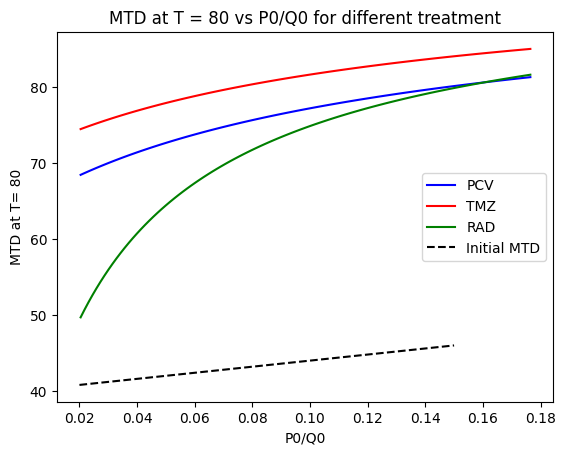

In [6]:
def MTDatT_vs_P0Q0(param, T):
    size = 50
    MTD = []
    rapport = []
    r = np.linspace(0.02, 0.15, 100)
    #We assume P0 will vary in 2% to 15% of DT

    for i in r:
        P0 = i*size
        Q0 = size - P0
        t = np.linspace(0, T, 500)
        y = odeint(derivees, (1.0, P0, Q0, 0.0), t, args=(param, ))
        MTD += [y[-1, 1] + y[-1, 2] + y[-1, 3]]
        rapport += [P0/Q0]

    return rapport, MTD

results_PCV = MTDatT_vs_P0Q0(parameters_PCV, 80)
results_TMZ = MTDatT_vs_P0Q0(parameters_TMZ, 80)
results_rad = MTDatT_vs_P0Q0(parameters_rad, 80)

plt.plot(results_PCV[0], results_PCV[1], 'b', label = 'PCV')
plt.plot(results_TMZ[0], results_TMZ[1], 'r', label = 'TMZ')
plt.plot(results_rad[0], results_rad[1], 'g', label = 'RAD')
plt.plot(initial_Pstar()[0], initial_Pstar()[1], 'black', linestyle='--', label = 'Initial MTD')

plt.xlabel('P0/Q0')
plt.ylabel('MTD at T= 80')
plt.title('MTD at T = 80 vs P0/Q0 for different treatment')

plt.legend()
plt.show()


For these plot we consider the mean population parameters. We look at the evolution of the MTD for different tratments over 80 months. 

We see that for the 3 treatments the bigger P0/Q0 the bigger will be the mean size of the MTD or the size at the end of the 80 months. Therefore P0/Q0 seems to be important to determine the outcome of the tumor after treatment.

On the figure below we see that if we look at tumor at 40 months, there are some sets of P0/Q0 for which the MTD decrease compared to the initial condition, we suggest an improvment of patient condition. This is especially the case for radiotherapy. 

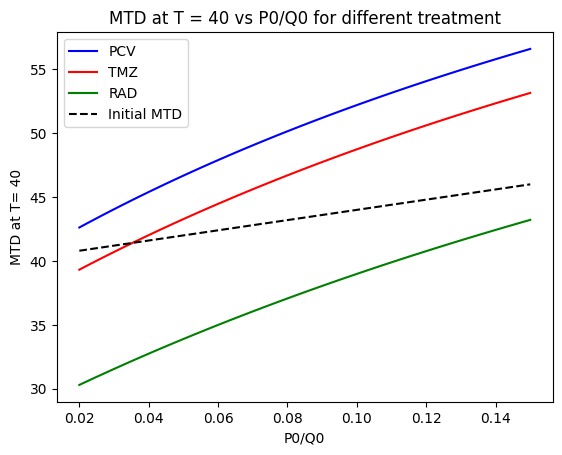

In [104]:
results_PCV = MTDatT_vs_P0Q0(parameters_PCV, 40)
results_TMZ = MTDatT_vs_P0Q0(parameters_TMZ, 40)
results_rad = MTDatT_vs_P0Q0(parameters_rad, 40)

plt.plot(results_PCV[0], results_PCV[1], 'b', label = 'PCV')
plt.plot(results_TMZ[0], results_TMZ[1], 'r', label = 'TMZ')
plt.plot(results_rad[0], results_rad[1], 'g', label = 'RAD')

plt.xlabel('P0/Q0')
plt.ylabel('MTD at T= 40')
plt.title('MTD at T = 40 vs P0/Q0 for different treatment')
plt.plot(initial_Pstar()[0], initial_Pstar()[1], 'black', linestyle='--', label = 'Initial MTD')

plt.legend()
plt.show()

The main difference betwwen radiotherapy and the other treatment is the value of the mean $\gamma$ (1.71) which is considerably higher than for both chemotherapy (PCV = 0.729 and TMZ = 0.842). 

But first let's look at the effect of  $\lambda_{p}$. We plot a heatmap with the color corresponding to the mean MTD given a $\lambda_{p}$ and P0/Q0.

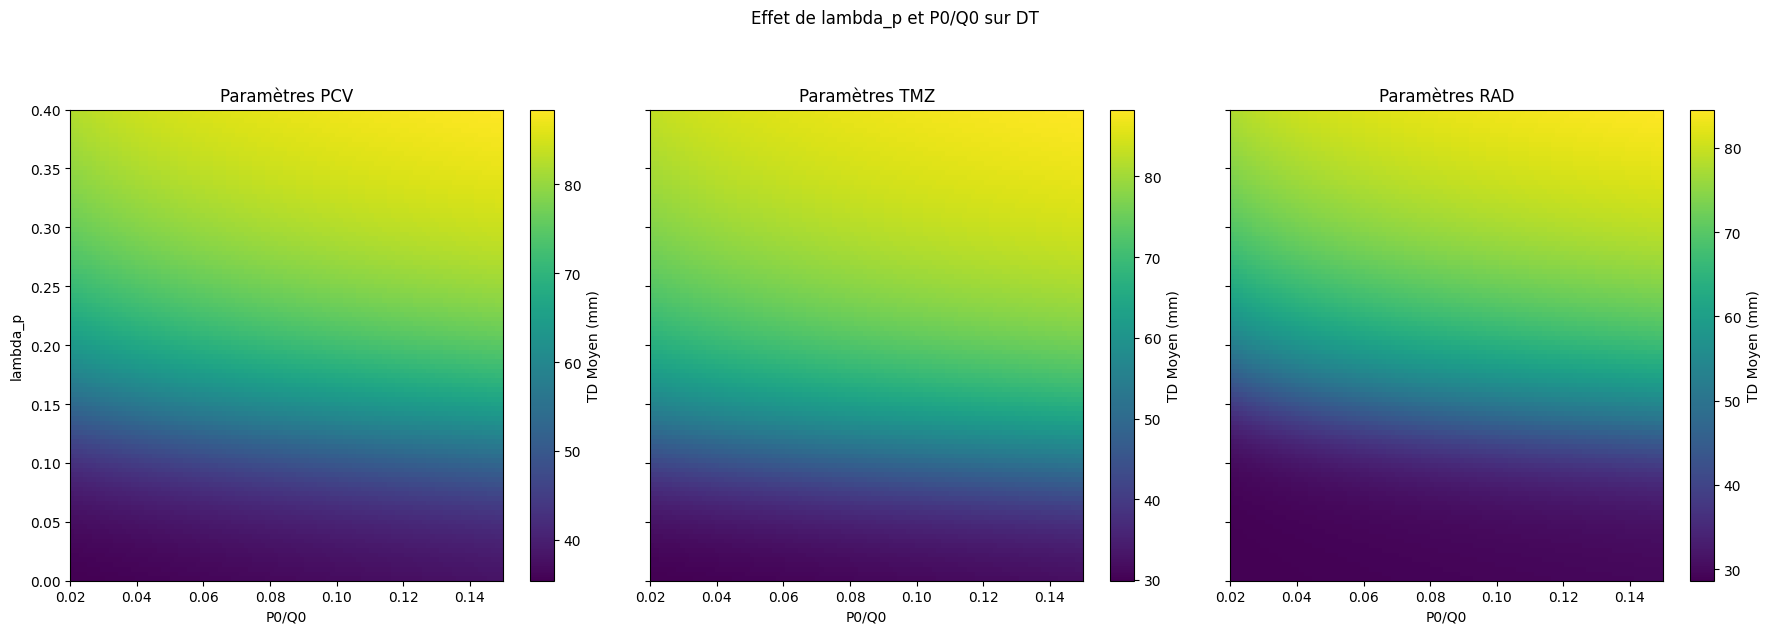

In [7]:
def plot_heatmap_MTD(param, T):
    values = []
    lambda_values = np.linspace(0, 0.4, 100)
    for lambda_p in lambda_values:
        param["lambda_p"] = lambda_p
        values += [meanMTD_vs_P0Q0(param, T)[1]]
        
    X = meanMTD_vs_P0Q0(param, T)[0]
    Y = lambda_values

    return X, Y, values

T = np.linspace(0.02, 0.15, 100)
parameter_sets = [parameters_PCV, parameters_TMZ, parameters_rad]
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Loop over each parameter set to create the heatmap
for i, params in enumerate(parameter_sets):
    # Generate data for each heatmap
    X, Y, values = plot_heatmap_MTD(params,T)
    
    # Plot the heatmap in the current subplot
    heatmap = axs[i].imshow(values, extent=(min(X), max(X), min(Y), max(Y)), origin='lower', cmap='viridis', aspect='auto')
    
    # Add color bar specific to each subplot
    cbar = fig.colorbar(heatmap, ax=axs[i])
    cbar.set_label("TD Moyen (mm)")

    # Set axis labels and title for each subplot
    axs[i].set_xlabel("P0/Q0")
    axs[i].set_ylabel("lambda_p" if i == 0 else "")

# Adjust layout to prevent overlap
axs[0].set_title(f"Paramètres PCV")
axs[1].set_title(f"Paramètres TMZ")
axs[2].set_title(f"Paramètres RAD")
plt.suptitle("Effet de lambda_p et P0/Q0 sur DT", y=1.05)
plt.tight_layout()

plt.show()

$\lambda_{p}$ appears to be much more determinant to determine the mean MTD over 80 months compared to P0/Q0. $\lambda_{p}$ has a interindividual variability of CV = 94% (so very high), so we assume that changes of $\lambda_{p}$ are gonna drive difference in patient response to treatment much more than P0 or Q0 (if P0 comprise between 2% and 15% of Q0 as it was observed). But actually this P0/Q0 could be much higher for young tumors (at first all tissue is proliferative, quiescience is linked to lack of nutrient). 

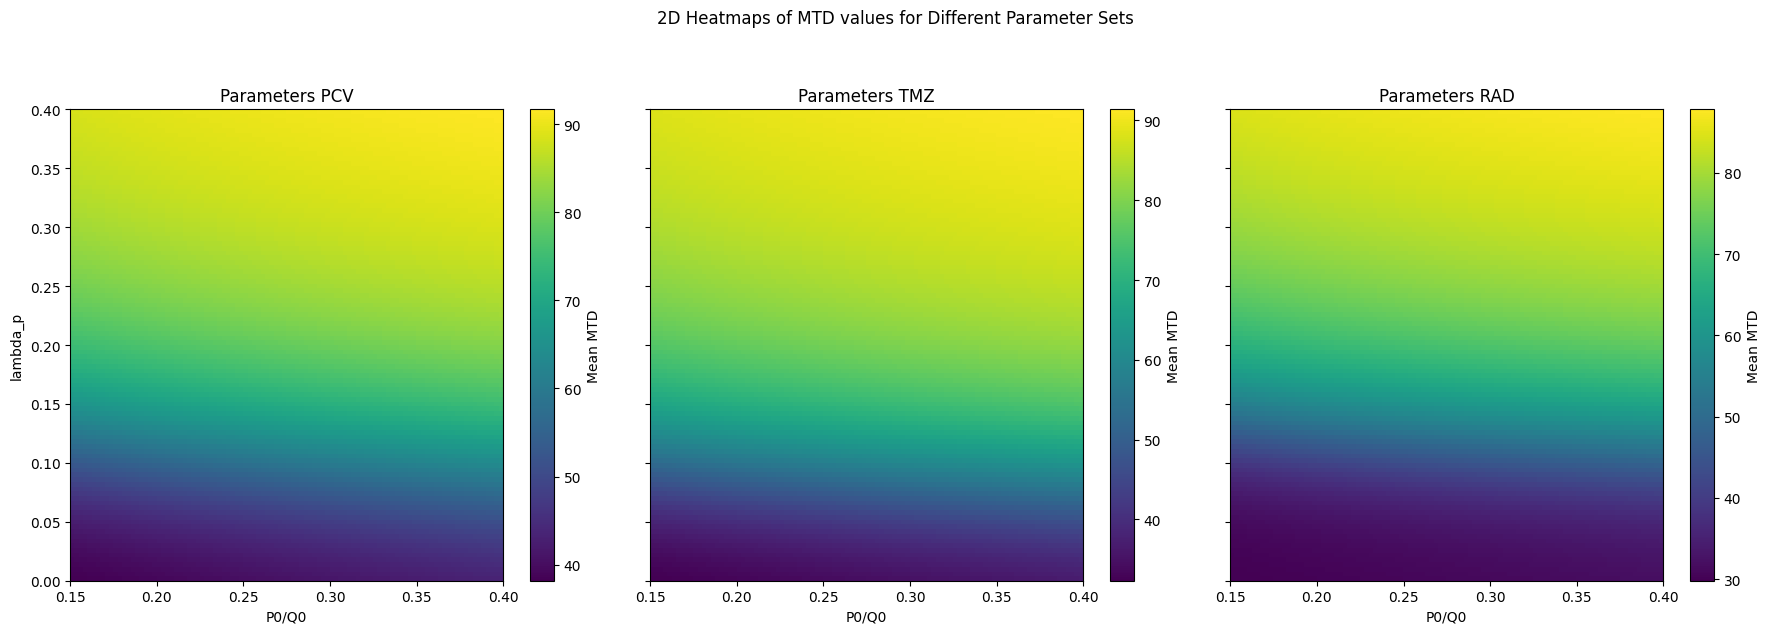

In [19]:
T = np.linspace(0.15, 0.40, 100)
parameter_sets = [parameters_PCV, parameters_TMZ, parameters_rad]
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Loop over each parameter set to create the heatmap
for i, params in enumerate(parameter_sets):
    # Generate data for each heatmap
    X, Y, values = plot_heatmap_MTD(params,T)
    
    # Plot the heatmap in the current subplot
    heatmap = axs[i].imshow(values, extent=(min(X), max(X), min(Y), max(Y)), origin='lower', cmap='viridis', aspect='auto')
    
    # Add color bar specific to each subplot
    cbar = fig.colorbar(heatmap, ax=axs[i])
    cbar.set_label("Mean MTD")

    # Set axis labels and title for each subplot
    axs[i].set_xlabel("P0/Q0")
    axs[i].set_ylabel("lambda_p" if i == 0 else "")
    axs[i].set_title(f"Parameter Set {i+1}")

# Adjust layout to prevent overlap
axs[0].set_title(f"Parameters PCV")
axs[1].set_title(f"Parameters TMZ")
axs[2].set_title(f"Parameters RAD")
plt.suptitle("2D Heatmaps of MTD values for Different Parameter Sets", y=1.05)
plt.tight_layout()

plt.show()

No clear change.

Now lets study the effect of $\gamma$, this parameters drives the death of P cells and the increase of Qp cells.

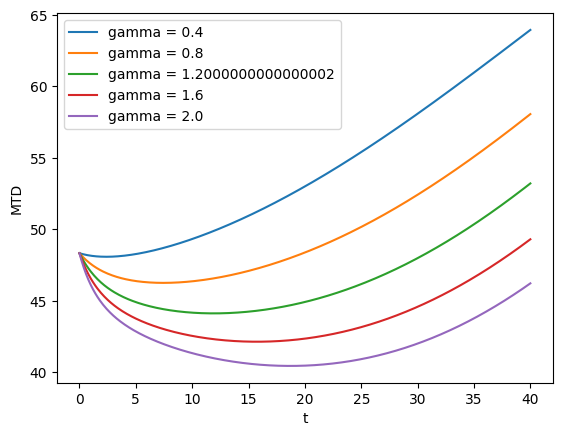

In [105]:
def gamma_evol(param):
    for gamma in np.linspace(0.4, 2, 5):
        param["gamma"] = gamma
        y_PCV = odeint(derivees, y0_PCV, np.linspace(0, 40, 400), args=(param, ))
        plt.plot(np.linspace(0, 40, 400), y_PCV[:, 1] + y_PCV[:, 2] + y_PCV[:, 3], label=f'gamma = {gamma}')
    plt.xlabel("t")
    plt.ylabel("MTD")   
    plt.legend()
    plt.show()

gamma_evol(parameters_PCV)   

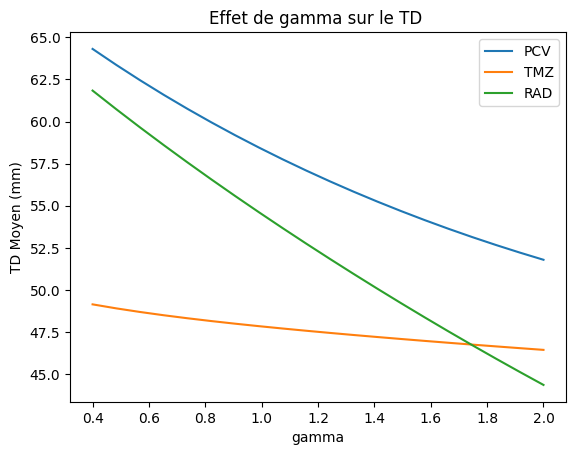

In [5]:
def meanMTD_f_gamma(param, gamma, P0, Q0):
    MTD_i= []
    X = []

    for i in gamma:
            t = np.linspace(0, 80, 800)
            param["gamma"] = i
            y = odeint(derivees, (1.0, P0, Q0, 0.0), t, args=(param, ))
            MTD_i += [np.mean(y[:, 1] + y[:, 2] + y[:, 3])]
            X += [i]

    return X, MTD_i

gamma = np.linspace(0.4, 2, 20)
X, MTD = meanMTD_f_gamma(parameters_PCV, gamma, y0_PCV[1], y0_PCV[2])
MTD_TMZ = meanMTD_f_gamma(parameters_TMZ, gamma, y0_TMZ[1], y0_TMZ[2])[1]
MTD_rad = meanMTD_f_gamma(parameters_rad, gamma, y0_rad[1], y0_rad[2])[1]

plt.plot(X, MTD, label=f'PCV')
plt.plot(X, MTD_TMZ, label=f'TMZ')
plt.plot(X, MTD_rad, label=f'RAD')

plt.xlabel("gamma")
plt.ylabel("TD Moyen (mm)") 
plt.title('Effet de gamma sur le TD ')

plt.legend()
plt.show()


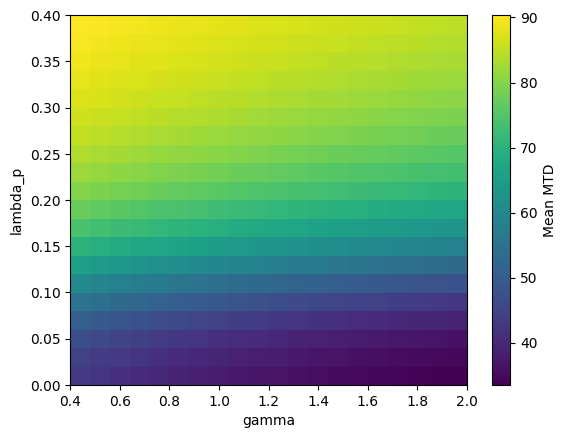

In [137]:
def meanMTD_f_gamma_lambda(param, gamma, lamb, P0, Q0):
    MTD = []
    X = []

    for j in lamb:
        param["lambda_p"] = j
        MTD += [meanMTD_f_gamma(param, gamma, P0, Q0)[1]]
        X += [j]
    Y = meanMTD_f_gamma(param, gamma, P0, Q0)[0]
    return X, Y, MTD

P0 = 7.13
Q0 = 41.2
gamma = np.linspace(0.4, 2, 20)
lamb = np.linspace(0.0, 0.4, 20)
X, Y, MTD = meanMTD_f_gamma_lambda(parameters_PCV, gamma, lamb, P0, Q0)

fig, axs = plt.subplots()
heatmap = axs.imshow(MTD, extent=(min(Y), max(Y), min(X), max(X)), origin='lower', cmap='viridis', aspect='auto')
    
    # Add color bar specific to each subplot
cbar = fig.colorbar(heatmap, ax=axs)
cbar.set_label("Mean MTD")

    # Set axis labels and title for each subplot
axs.set_xlabel("gamma")
axs.set_ylabel("lambda_p")
axs.set_title('')

plt.show()

Now let's look at the effect of C on the mean MTD.

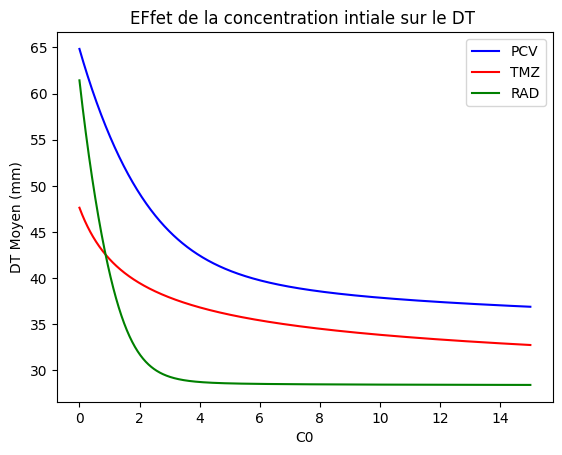

In [4]:
def meanMTD_vs_C(param, y0, C):
    MTD = []
    X = []

    for c in C:
        t = np.linspace(0, 60, 600)
        y = odeint(derivees, (c, y0[1], y0[2], 0.0), t, args=(param, ))
        MTD += [np.mean(y[:, 1] + y[:, 2] + y[:, 3])]
        X += [c]

    return X, MTD


C_values = np.linspace(0.0, 15, 1000)
results_PCV = meanMTD_vs_C(parameters_PCV, y0_PCV, C_values)
results_TMZ = meanMTD_vs_C(parameters_TMZ, y0_TMZ, C_values)
results_rad = meanMTD_vs_C(parameters_rad, y0_rad, C_values)

plt.plot(results_PCV[0], results_PCV[1], 'b', label = 'PCV')
plt.plot(results_TMZ[0], results_TMZ[1], 'r', label = 'TMZ')
plt.plot(results_rad[0], results_rad[1], 'g', label = 'RAD')

plt.xlabel('C0')
plt.ylabel('DT Moyen (mm)')
plt.title('EFfet de la concentration intiale sur le DT ')

plt.legend()
plt.show()

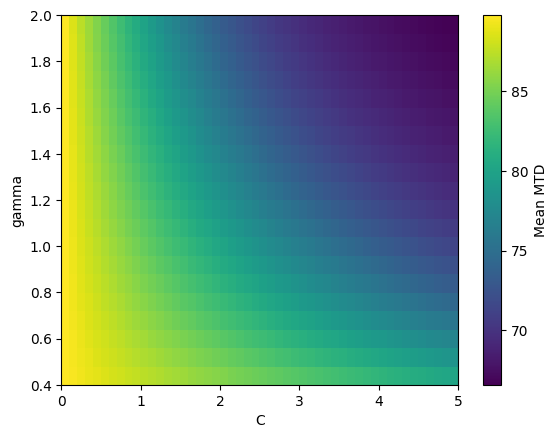

In [142]:
def meanMTD_f_gamma_C(param, gamma, C, y0):
    MTD = []
    X = []

    for j in gamma:
        param["gamma"] = j
        y = meanMTD_vs_C(param, y0, C)[1]
        #print(y)
        MTD += [y]
        X += [j]
    Y = meanMTD_vs_C(param, y0, C)[0]

    return X, Y, MTD


gamma = np.linspace(0.4, 2, 20)
C_values = np.linspace(0.0, 5, 50)

X, Y, MTD = meanMTD_f_gamma_C(parameters_PCV, gamma, C_values, y0_PCV)
#print(MTD)

fig, axs = plt.subplots()
heatmap = axs.imshow(MTD, extent=(min(Y), max(Y), min(X), max(X)), origin='lower', cmap='viridis', aspect='auto')
    
    # Add color bar specific to each subplot
cbar = fig.colorbar(heatmap, ax=axs)
cbar.set_label("Mean MTD")

    # Set axis labels and title for each subplot
axs.set_xlabel("C")
axs.set_ylabel("gamma")
axs.set_title('')

plt.show()

Increasing the dose C of at time 0 can only decrease the mean STD up to a certain point. We can assume that $\gamma$ is the on of the key component determining how fast the mean MTD converges.

However, it should also be noted that a dose of C to high could be harmful for patients. There is a risk/benefits balance to take into account. 

### Optimisation of time of injection for 1 injection

In [13]:
from optimisation import *
import time as t

_, P0, Q0, Qp0 = y0_PCV
n_inj = 1
C_tot = 1
t_stop = 80
start = t.perf_counter()

Result = find_optimal(n_inj, C_tot, P0, Q0, Qp0, 100, t_stop, parameters = parameters_PCV)
    
stop = t.perf_counter()
print("optimisation time", stop-start)
Temps_injections = Result   
print(Temps_injections)

optimisation time 0.552502400000094
(array([17.627507]), 64.9407309936576, 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH')


What is the optimal injection time in function of the length of observation of the tumor size when we apply one injection?

We print the results for the 3 different mean parameters.

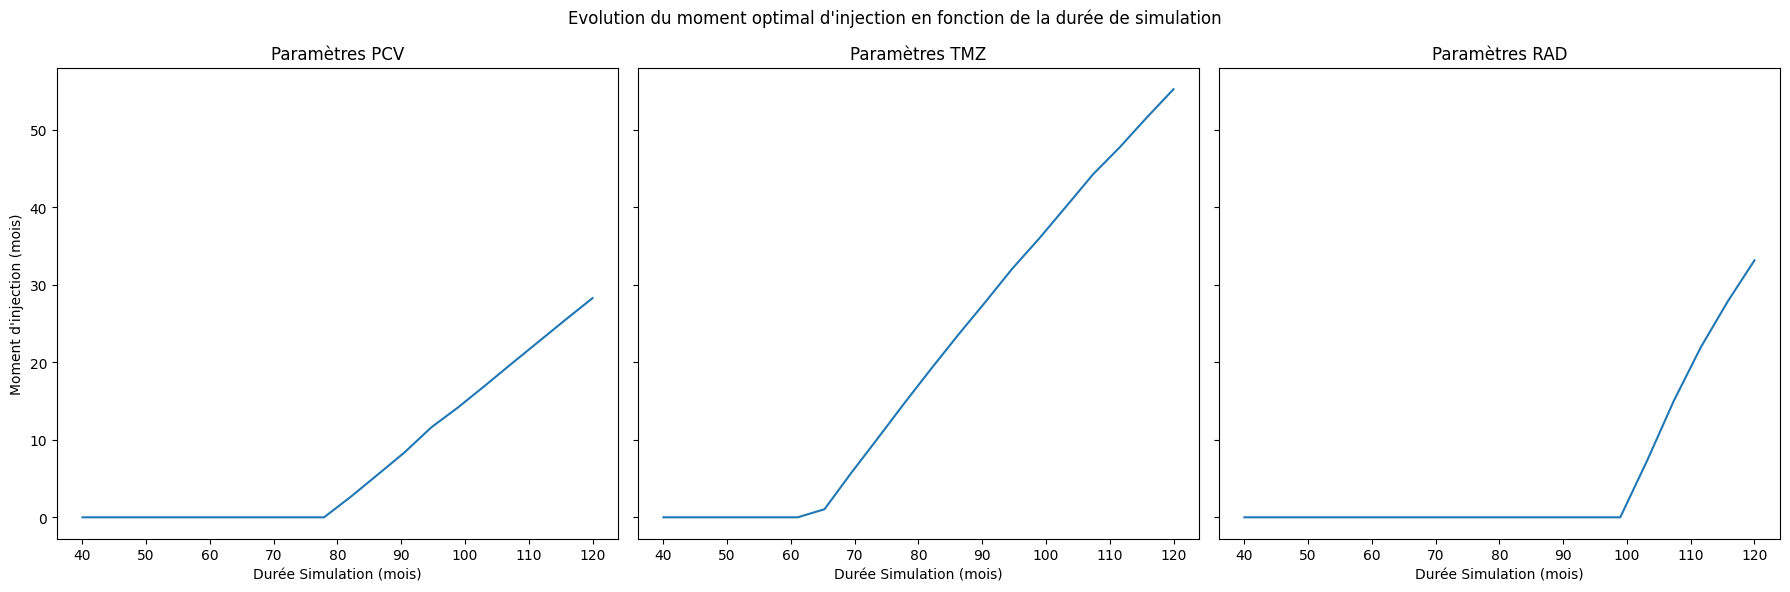

In [25]:
n_inj = 1
C_tot = 1


parameter_sets = [parameters_PCV, parameters_TMZ, parameters_rad]
initial_conditions = [y0_PCV, y0_TMZ, y0_rad]
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
for i, params in enumerate(copy.deepcopy(parameter_sets)):
    Y = []
    for t_stop in np.linspace(20, 120, 20):

        Result = find_optimal(n_inj, C_tot, initial_conditions[i][1], initial_conditions[i][2], initial_conditions[i][3], t_stop, 100, parameters = params)
        Y += [Result[0]]
    axs[i].plot(np.linspace(40, 120, 20), Y)
    axs[i].set_xlabel('Durée Simulation (mois)')
    axs[i].set_ylabel("Moment d'injection (mois)" if i == 0 else "")

axs[0].set_title(f"Paramètres PCV")
axs[1].set_title(f"Paramètres TMZ")
axs[2].set_title(f"Paramètres RAD")
plt.suptitle("Evolution du moment optimal d'injection en fonction de la durée de simulation")
plt.tight_layout()

plt.show()


What can explain the differences in optimal injection time given different parameters set? To study this, let's look at the evolution of $\lambda_{p}$ a key parameter to determnine the dynamics of tumor, on injection time.

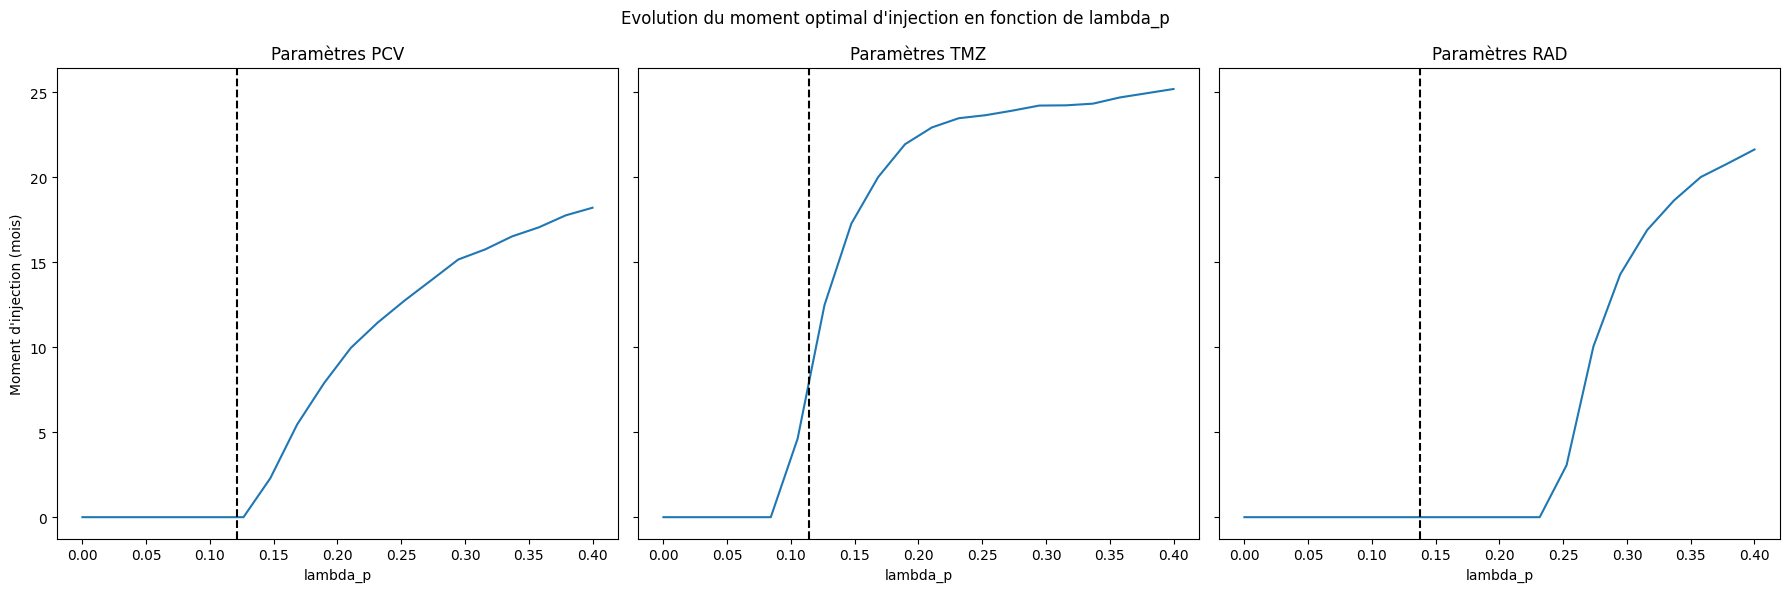

In [26]:
n_inj = 1
C_tot = 1
t_stop = 60

parameter_sets = [parameters_PCV, parameters_TMZ, parameters_rad]
initial_conditions = [y0_PCV, y0_TMZ, y0_rad]
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
for i, params in enumerate(copy.deepcopy(parameter_sets)):
    Y = []
    for l in np.linspace(0, 0.4, 20):
        params["lambda_p"] = l
        Result = find_optimal(n_inj, C_tot, initial_conditions[i][1], initial_conditions[i][2], initial_conditions[i][3], t_stop, 100, parameters = params)
        Y += [Result[0]]
    axs[i].plot(np.linspace(0, 0.4, 20), Y)
    axs[i].axvline(x = parameter_sets[i]["lambda_p"], color='black', linestyle='--')
    axs[i].set_xlabel('lambda_p')
    axs[i].set_ylabel("Moment d'injection (mois)" if i == 0 else "")

axs[0].set_title(f"Paramètres PCV")
axs[1].set_title(f"Paramètres TMZ")
axs[2].set_title(f"Paramètres RAD")
plt.suptitle("Evolution du moment optimal d'injection en fonction de lambda_p")
plt.tight_layout()

plt.show()

In this case, the simulation is lasts 60 month, and we saw on the previous figure that for all parameters if t_stop < 60, the optimal injection time was 0. But here we see that if we consider lambda_p higher than its mean value for the different treatment, then the optimal injection time becomes non zero. (the mean value of $\lambda_{p}$ for each treatment corresponds to the dashed line). 

But what is the impact on P0, Q0 and P0/Q0.

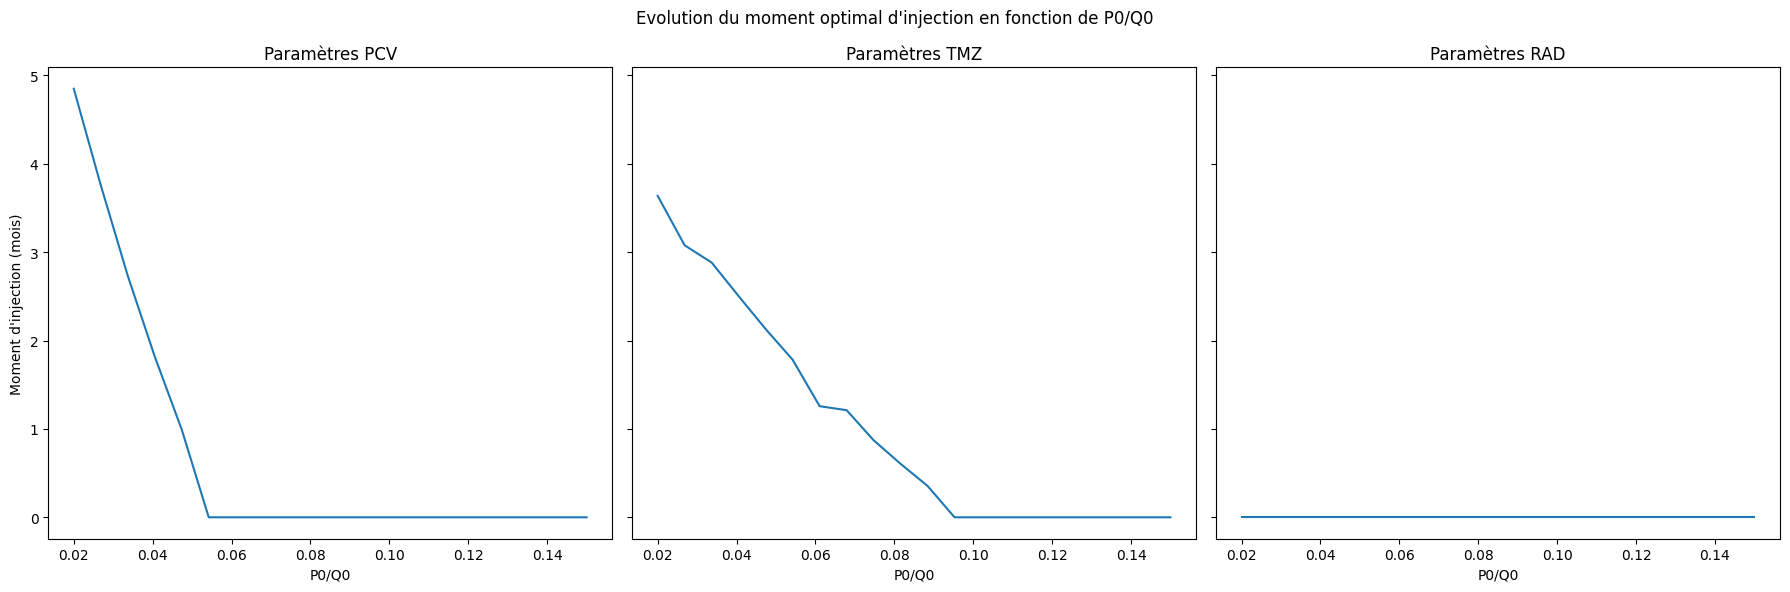

In [27]:
n_inj = 1
C_tot = 1
t_stop = 60
size = 50

parameter_sets = [parameters_PCV, parameters_TMZ, parameters_rad]

fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
for i, params in enumerate(copy.deepcopy(parameter_sets)):
    Y = []
    for p in np.linspace(0.02, 0.15, 20):
        P0 = p*size
        Q0 = size - P0
        Result = find_optimal(n_inj, C_tot, P0, Q0, 0, t_stop, 100, parameters = params)
        Y += [Result[0]]
    axs[i].plot(np.linspace(0.02, 0.15, 20), Y)
    axs[i].set_xlabel('P0/Q0')
    axs[i].set_ylabel("Moment d'injection (mois)" if i == 0 else "")

axs[0].set_title(f"Paramètres PCV")
axs[1].set_title(f"Paramètres TMZ")
axs[2].set_title(f"Paramètres RAD")
plt.suptitle("Evolution du moment optimal d'injection en fonction de P0/Q0")
plt.tight_layout()

plt.show()

### Optimisation of time of injection for 2 injections

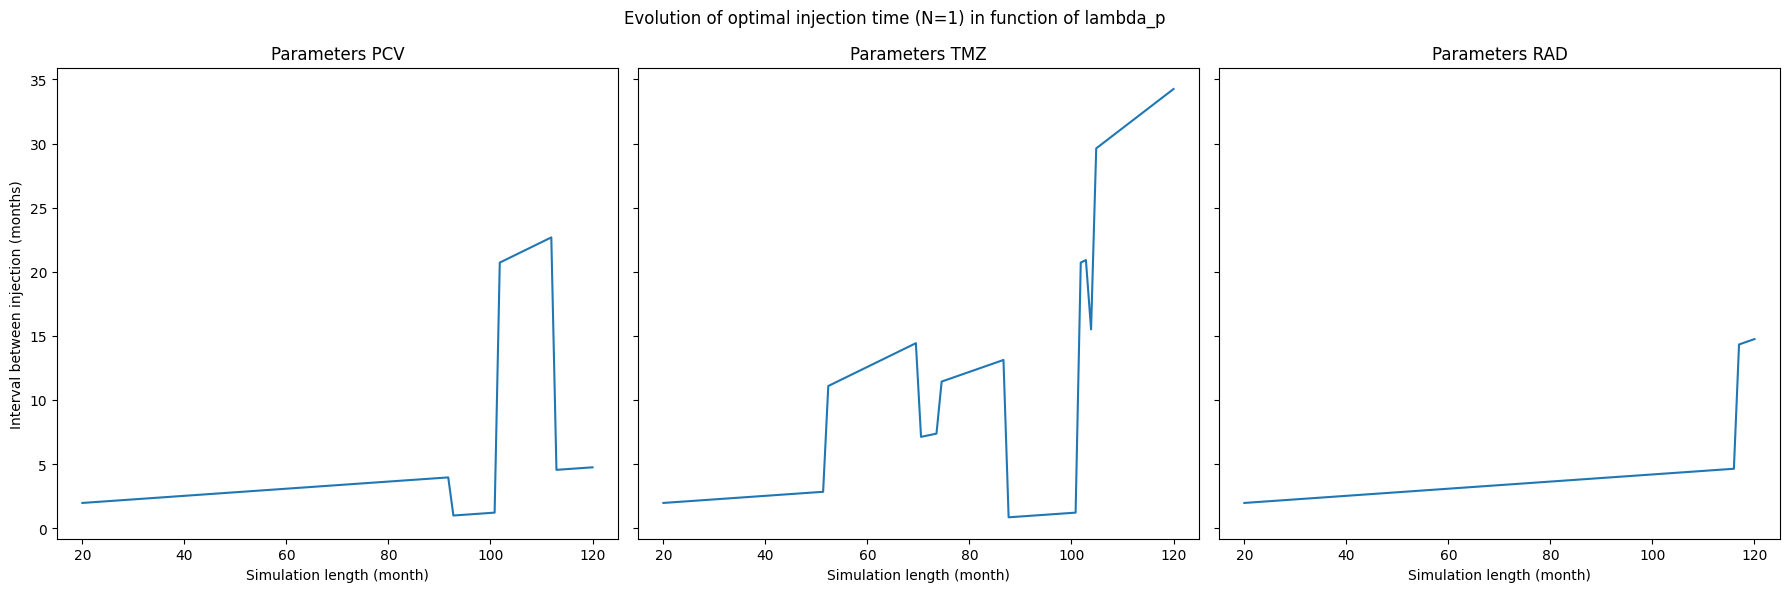

In [165]:
n_inj = 2
C_tot = 1


parameter_sets = [parameters_PCV, parameters_TMZ, parameters_rad]
initial_conditions = [y0_PCV, y0_TMZ, y0_rad]
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
for i, params in enumerate(copy.deepcopy(parameter_sets)):
    DT = []
    injec_1 = 0
    for t_stop in np.linspace(20, 120, 100):

        Result = find_optimal(n_inj, C_tot, initial_conditions[i][1], initial_conditions[i][2], initial_conditions[i][3], t_stop, maxfun=10, parameters = params)
        DT += [abs(Result.x[0] - Result.x[1])]

    axs[i].plot(np.linspace(20, 120, 100), DT)
    axs[i].set_xlabel('Simulation length (month)')
    axs[i].set_ylabel('Interval between injection (months)' if i == 0 else "")

axs[0].set_title(f"Parameters PCV")
axs[1].set_title(f"Parameters TMZ")
axs[2].set_title(f"Parameters RAD")
plt.suptitle('Evolution of optimal injection time (N=1) in function of lambda_p')
plt.tight_layout()

plt.show()

    

EEUUUHH C'est pas clair mais quand la simu dure moins de 40 en gros on les 2 sont plutot proche.

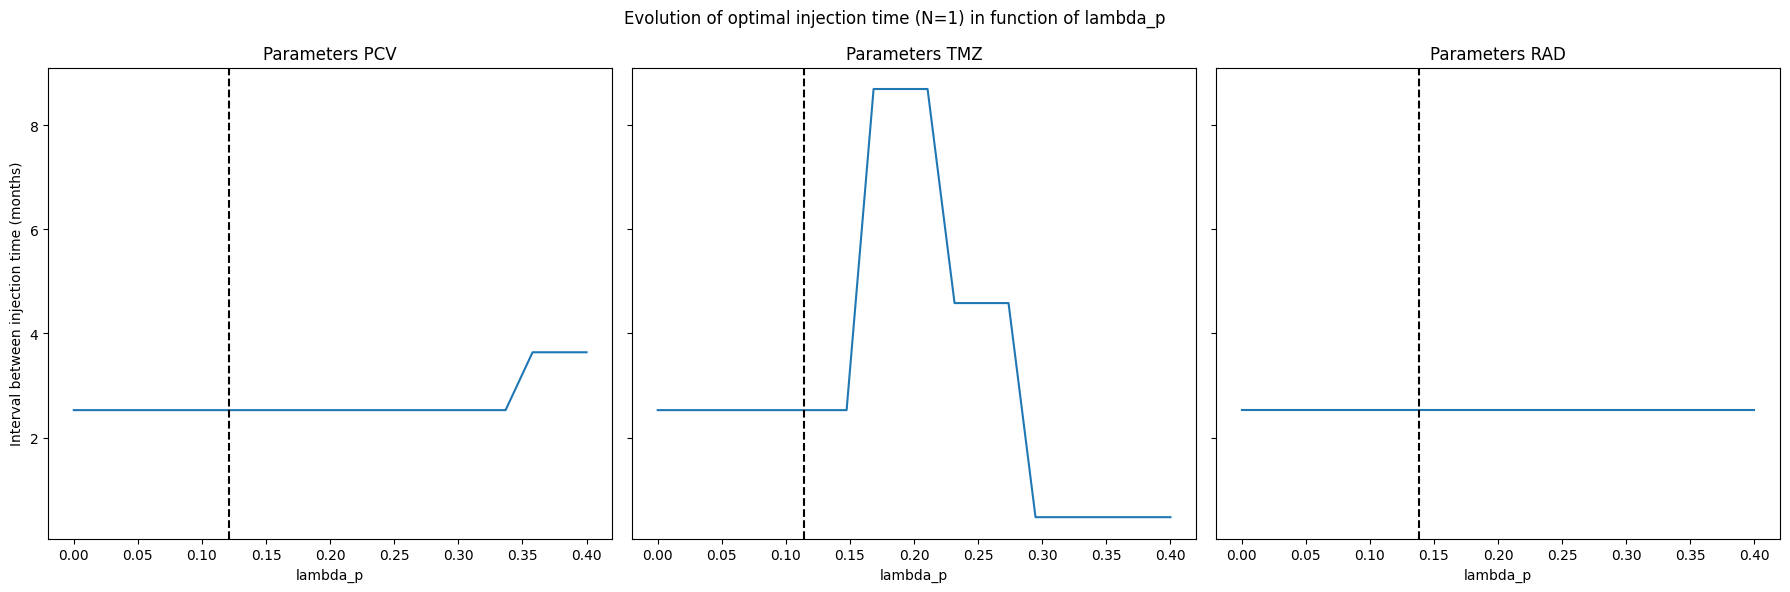

In [168]:
n_inj = 2
C_tot = 1
t_stop = 40

parameter_sets = [parameters_PCV, parameters_TMZ, parameters_rad]
initial_conditions = [y0_PCV, y0_TMZ, y0_rad]
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
for i, params in enumerate(copy.deepcopy(parameter_sets)):
    Y = []
    for l in np.linspace(0, 0.4, 20):
        params["lambda_p"] = l
        Result = find_optimal(n_inj, C_tot, initial_conditions[i][1], initial_conditions[i][2], initial_conditions[i][3], t_stop, maxfun=10, parameters = params)
        Y += [abs(Result.x[0] - Result.x[1])]
    axs[i].plot(np.linspace(0, 0.4, 20), Y)
    axs[i].axvline(x = parameter_sets[i]["lambda_p"], color='black', linestyle='--')
    axs[i].set_xlabel('lambda_p')
    axs[i].set_ylabel('Interval between injection time (months)' if i == 0 else "")

axs[0].set_title(f"Parameters PCV")
axs[1].set_title(f"Parameters TMZ")
axs[2].set_title(f"Parameters RAD")
plt.suptitle('Evolution of optimal injection time (N=1) in function of lambda_p')
plt.tight_layout()

plt.show()

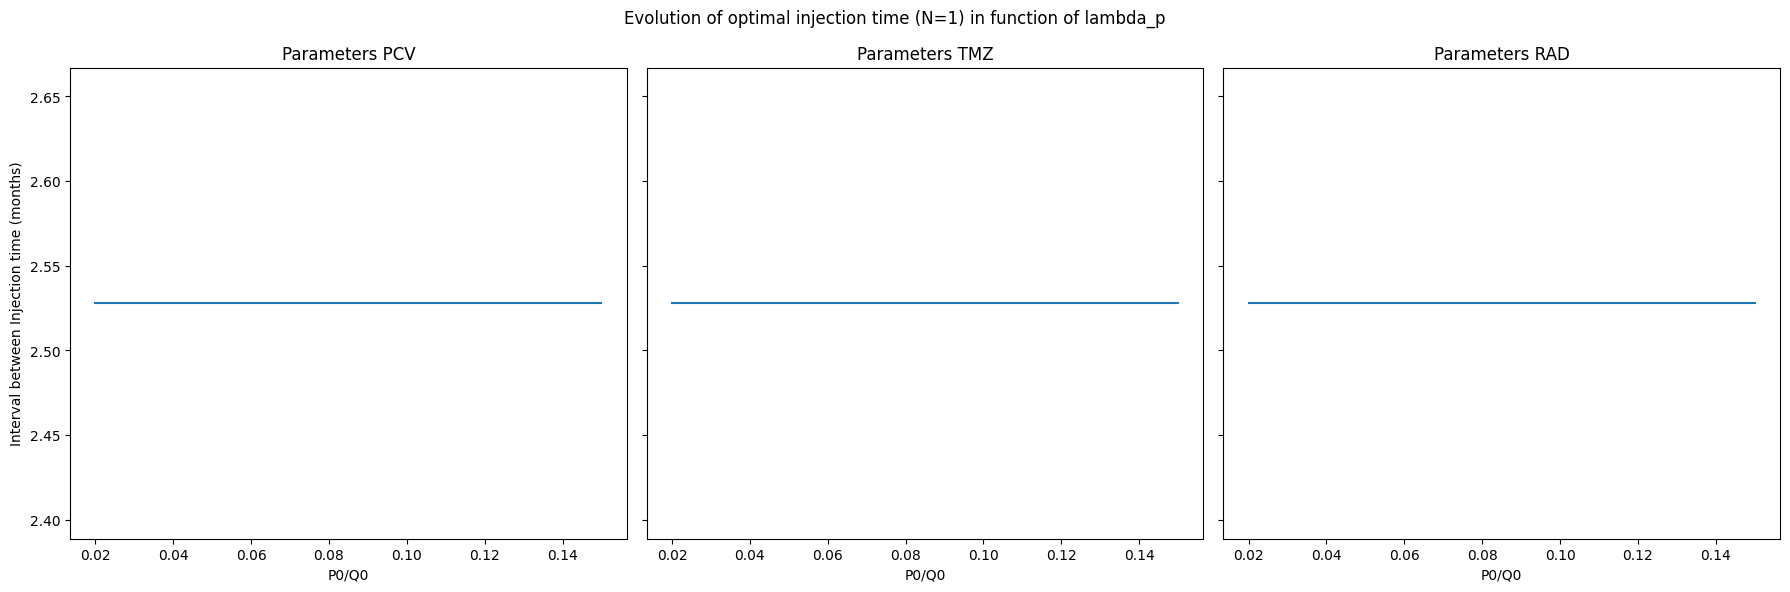

In [169]:
n_inj = 2
C_tot = 1
t_stop = 40
size = 50

parameter_sets = [parameters_PCV, parameters_TMZ, parameters_rad]

fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
for i, params in enumerate(copy.deepcopy(parameter_sets)):
    Y = []
    for p in np.linspace(0.02, 0.15, 20):
        P0 = p*size
        Q0 = size - P0
        Result = find_optimal(n_inj, C_tot, P0, Q0, 0, t_stop, maxfun=10, parameters = params)
        Y += [abs(Result.x[0] - Result.x[1])]
    axs[i].plot(np.linspace(0.02, 0.15, 20), Y)
    axs[i].set_xlabel('P0/Q0')
    axs[i].set_ylabel('Interval between Injection time (months)' if i == 0 else "")

axs[0].set_title(f"Parameters PCV")
axs[1].set_title(f"Parameters TMZ")
axs[2].set_title(f"Parameters RAD")
plt.suptitle('Evolution of optimal injection time (N=1) in function of lambda_p')
plt.tight_layout()

plt.show()